Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
import os
# Add the src folder to the system path
project_path = os.path.abspath('..')  # Adjust based on the actual project structure
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:  # Avoid adding duplicates
    sys.path.append(src_path)

from data_preprocessing import handle_missing_values
from feature_engineering import generate_date_features
from utils import save_visualization, log_exception


Set Up Logging

In [2]:
logging.basicConfig(
    filename='../logs/preprocessing.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logging.info("Notebook started for preprocessing.")


Load Data

In [3]:
try:
    train = pd.read_csv('../data/train.csv')
    test = pd.read_csv('../data/test.csv')
    store = pd.read_csv('../data/store.csv')
    logging.info("Datasets loaded successfully.")
except Exception as e:
    logging.error(f"Error loading datasets: {e}")
    log_exception(e)
    raise e
display(train.head(), test.head(), store.head())


C:\Users\hp\AppData\Local\Temp\ipykernel_8940\2382627119.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
print(store.info())
print(store.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                      

Handle Missing Values

In [5]:
try:
    train, test, store = handle_missing_values(train, test, store)
    logging.info("Missing values handled.")
except Exception as e:
    logging.error(f"Error handling missing values: {e}")
    log_exception(e)
    raise e


In [6]:
train, test, store = handle_missing_values(train, test, store)

# Check if there are still missing values
print(store.isnull().sum())


Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


Feature Engineering

In [7]:
try:
    train = generate_date_features(train)
    test = generate_date_features(test)
    logging.info("Date features generated successfully.")
except Exception as e:
    logging.error(f"Error in feature engineering: {e}")
    log_exception(e)
    raise e
display(train.head())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Weekday,IsWeekend,Month,Year,Day,DaysToHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,4,False,7,2015,31,3800
1,2,5,2015-07-31,6064,625,1,1,0,1,4,False,7,2015,31,3800
2,3,5,2015-07-31,8314,821,1,1,0,1,4,False,7,2015,31,3800
3,4,5,2015-07-31,13995,1498,1,1,0,1,4,False,7,2015,31,3800
4,5,5,2015-07-31,4822,559,1,1,0,1,4,False,7,2015,31,3800


Scaling the Data

In [9]:
try:
    # Identify numeric columns that are common to both train and test
    train_numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
    test_numeric_columns = test.select_dtypes(include=['float64', 'int64']).columns
    
    # Find common numeric columns
    common_numeric_columns = train_numeric_columns.intersection(test_numeric_columns)
    
    # Scale only the common numeric columns
    scaler = StandardScaler()
    train[common_numeric_columns] = scaler.fit_transform(train[common_numeric_columns])
    test[common_numeric_columns] = scaler.transform(test[common_numeric_columns])
    
    logging.info("Data scaled successfully.")
except Exception as e:
    logging.error(f"Error during scaling: {e}")
    log_exception(e)
    raise e

# Display the scaled data
display(train.head(), test.head())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Weekday,IsWeekend,Month,Year,Day,DaysToHoliday
0,-1.731640,0.501484,2015-07-31,-0.132683,-0.168269,0.452399,1.273237,0,2.144211,4,False,7,2015,31,-1.734123
1,-1.728534,0.501484,2015-07-31,0.075373,-0.017540,0.452399,1.273237,0,2.144211,4,False,7,2015,31,-1.734123
2,-1.725427,0.501484,2015-07-31,0.659800,0.404499,0.452399,1.273237,0,2.144211,4,False,7,2015,31,-1.734123
3,-1.722321,0.501484,2015-07-31,2.135414,1.862258,0.452399,1.273237,0,2.144211,4,False,7,2015,31,-1.734123
4,-1.719214,0.501484,2015-07-31,-0.247231,-0.159656,0.452399,1.273237,0,2.144211,4,False,7,2015,31,-1.734123


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Weekday,IsWeekend,Month,Year,Day,DaysToHoliday
0,1,1.0,4.0,2015-09-17,1.0,1.0,0,1.068459e-16,3,False,9,2015,17,3752.0
1,2,3.0,4.0,2015-09-17,1.0,1.0,0,1.068459e-16,3,False,9,2015,17,3752.0
2,3,7.0,4.0,2015-09-17,1.0,1.0,0,1.068459e-16,3,False,9,2015,17,3752.0
3,4,8.0,4.0,2015-09-17,1.0,1.0,0,1.068459e-16,3,False,9,2015,17,3752.0
4,5,9.0,4.0,2015-09-17,1.0,1.0,0,1.068459e-16,3,False,9,2015,17,3752.0


Visualizations

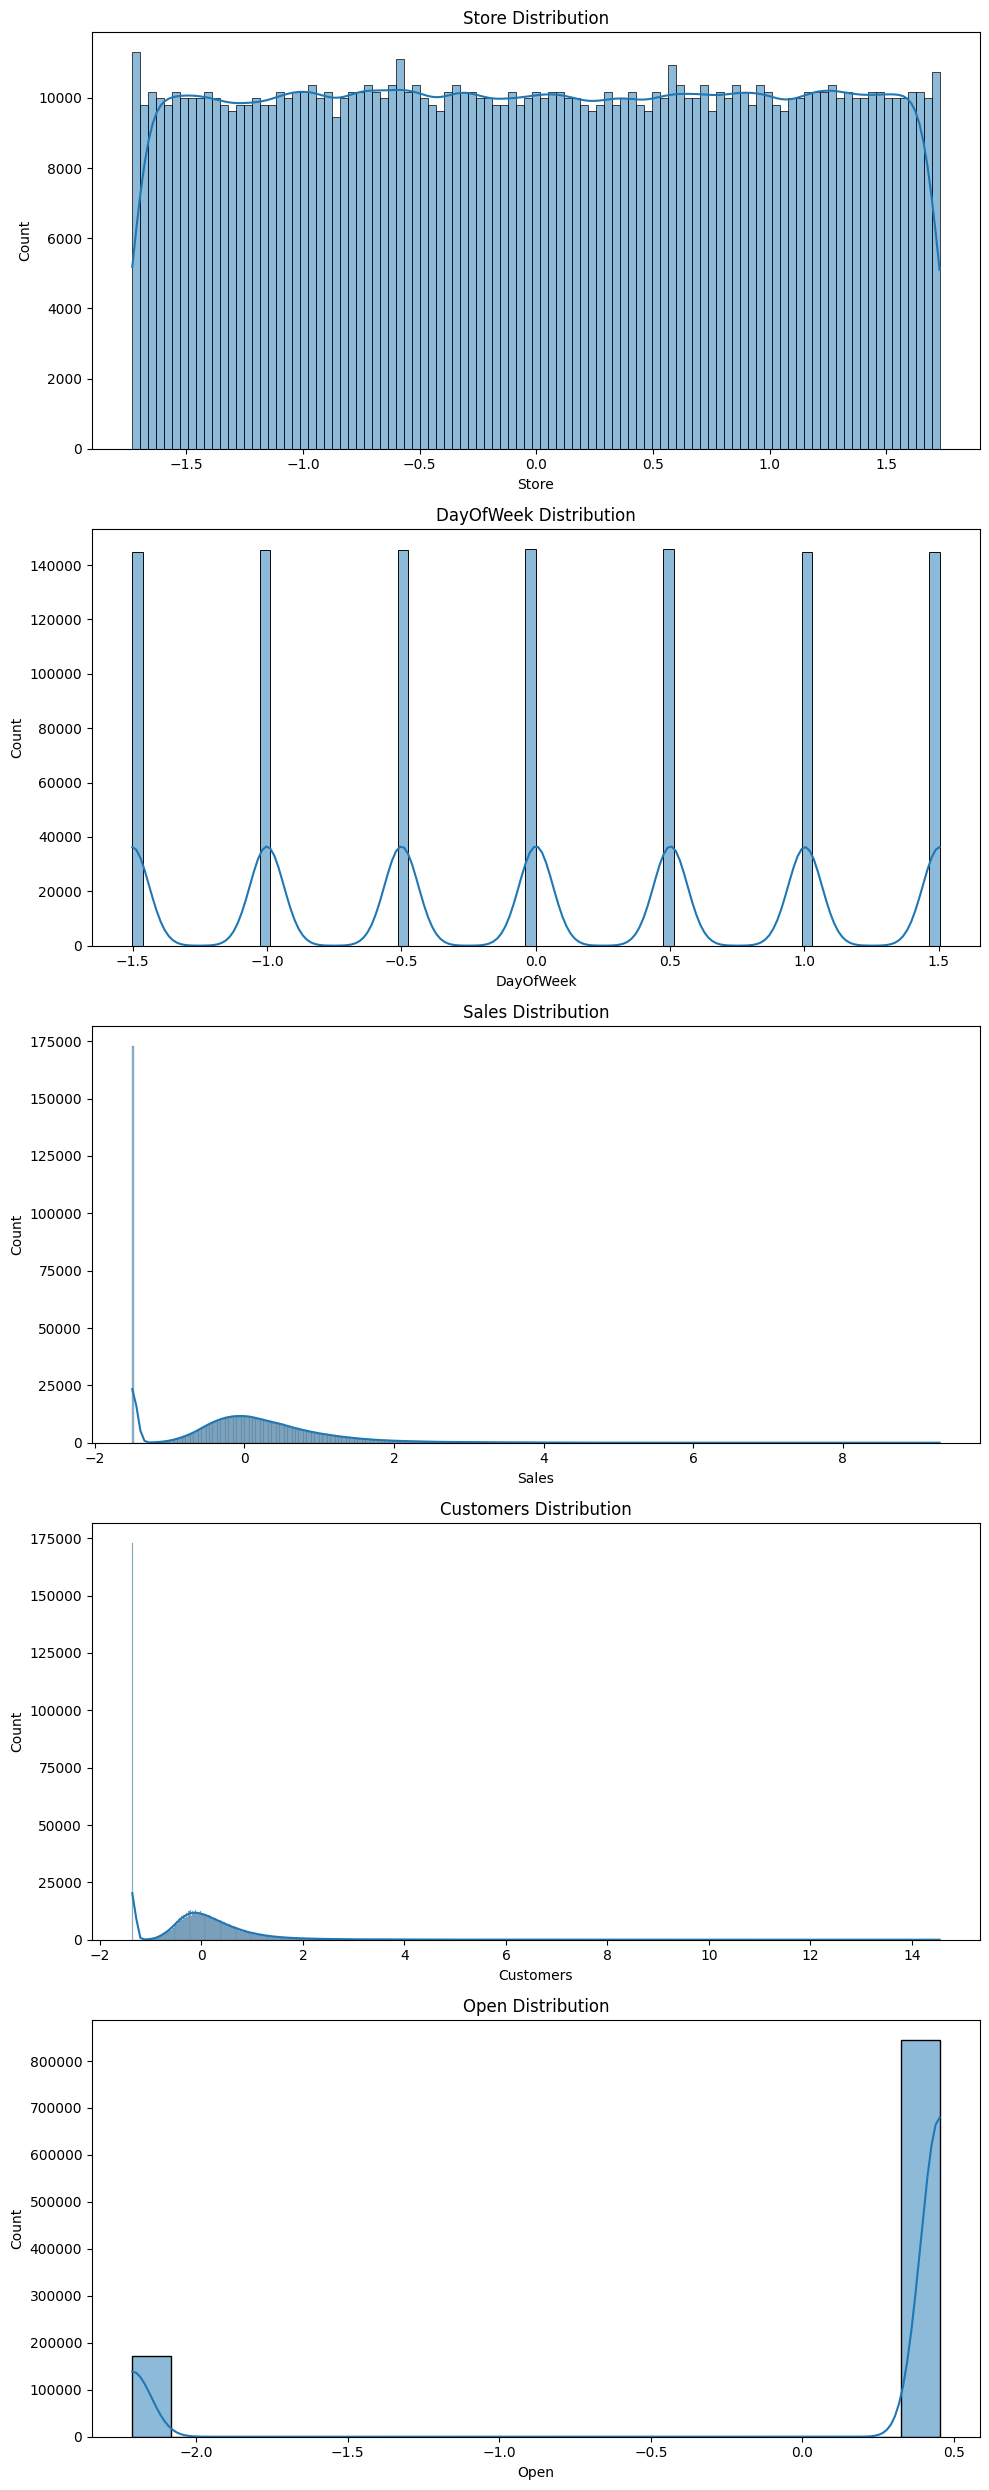

In [11]:
def plot_distributions(data, columns, title):
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))
    for i, col in enumerate(columns):
        sns.histplot(data[col], kde=True, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
    plt.tight_layout()
    plt.show() 
    save_visualization(fig, title)

try:
    plot_distributions(train, numeric_columns[:5], 'numeric_feature_distributions')
    logging.info("Visualizations saved successfully.")
except Exception as e:
    logging.error(f"Error during visualization: {e}")
    log_exception(e)
    raise e
